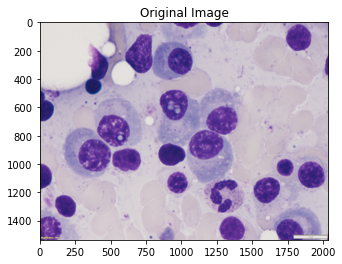

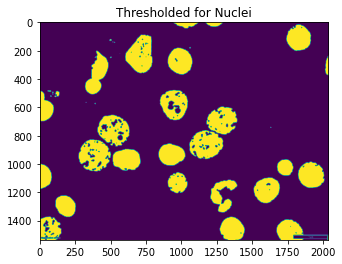

<class 'numpy.ndarray'>


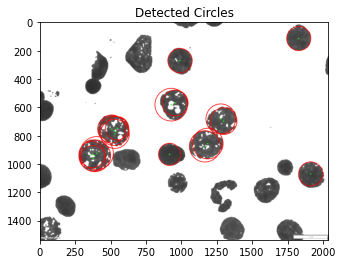

Number of elements:  7


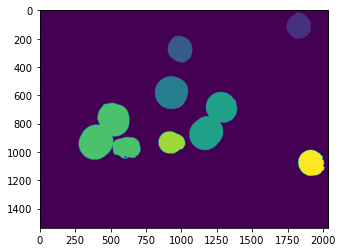

Number of elements:  13


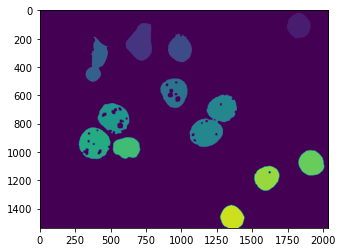

1 and 1
2 and 3
3 and 5
4 and 6
5 and 7
5 and 8
5 and 9


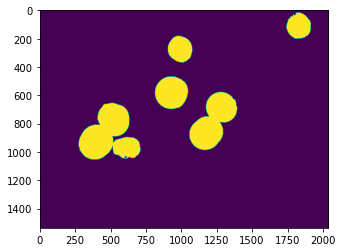

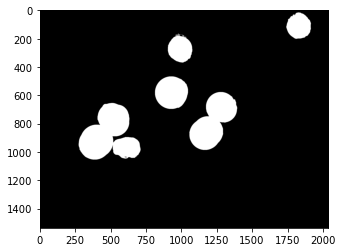

['1985_2.bmp', '1985_6.bmp', '1985_4.bmp', '1985_5.bmp']
1/4 1985_2.bmp
2/4 1985_6.bmp
3/4 1985_4.bmp
4/4 1985_5.bmp


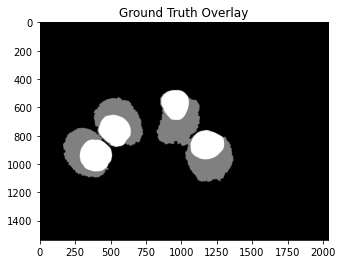

Nuc Count 4
Cyt Count 4
((0.5714285714285714, 1.0, 0.7272727272727273), (0.3076923076923077, 1.0, 0.47058823529411764), (4, 3, 0), (4, 9, 0))


In [38]:
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import cv2
from os import listdir
from os.path import exists, isfile
from scipy.spatial import distance
from scipy.ndimage import measurements
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.measurements.label.html

def get_mnms(fName):
    
    original_image = io.imread(fName)

    plt.imshow(original_image)
    plt.title('Original Image')
    plt.show()
    
    original_image_grey = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    #plt.imshow(original_image_grey, cmap = 'gray')
    #plt.title('Original Image Greyscale')
    #plt.show()

    hist, bins = np.histogram(original_image_grey, bins = 256, range = [0,256])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    #plt.bar(center, hist, align = 'center', width = width)
    #plt.title('Greyscale Histogram of Original Image')
    #plt.show()
    
    threshold_of_original_grey = original_image_grey < 112
    plt.imshow(threshold_of_original_grey)
    plt.title('Thresholded for Nuclei')
    plt.show()
    
    

    #plt.imshow(threshold_of_original_grey, cmap = 'gray')
    #plt.title('Threshold Image')
    #plt.show()
    
    image_for_hough_circles = np.ndarray((len(original_image), len(original_image[0]), 3), "uint8") #rows, cols, channel(RGB)
    #Above makes new 2D array, so that can turn our binary image into greyscale. 
    #Hough transform did not take binary, therefore these loops will make the points in the binary image which are
    # zero (background) = to an intensity value of 256 (bright background, dark 'nucleus')

    for row in range(len(original_image)):
        for col in range(len(original_image[0])):
            if threshold_of_original_grey[row][col] == 0:
                image_for_hough_circles[row, col] = [255, 255, 255]
            else:
                image_for_hough_circles[row, col] = original_image[row, col]

    #plt.imshow(image_for_hough_circles, cmap = 'gray')
    #plt.title('image_for_hough_circles before Hough Transform')
    #plt.show()
    
    image_for_hough_circles = cv2.cvtColor(image_for_hough_circles, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image_for_hough_circles, 30, 75)
    #plt.imshow(edges, cmap = 'gray')
    #plt.title('Edge Detection')
    #plt.show()
    
    maxRadius = 135
    while True:
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20, 
                                 param1=70, param2=25,
                                 minRadius=72, maxRadius=maxRadius)
        print(str(type(circles)))
        if circles is None:
            maxRadius += 15
        else:
            break

    circles = np.uint16(np.around(circles))

    cimg = cv2.cvtColor(image_for_hough_circles, cv2.COLOR_GRAY2RGB)

    # the list that will hold the center of the detected nuclei
    center_nuclei = circles[0, :, 0:2]
    radius = circles[0, :, 2]

    for i in circles[0,:]:
        # draw the outer circle
        cv2.circle(cimg,(i[0],i[1]),i[2],(255,0,0),3) #RGB
        # draw the center of the circle
        cv2.circle(cimg,(i[0],i[1]),2,(0,255,0),5)

    cv2.imwrite('img_circles.png', cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB))
    plt.imshow(cimg)
    plt.title('Detected Circles')
    plt.show()
    
    x = len(threshold_of_original_grey) #Number of rows in image
    y = len(threshold_of_original_grey[0]) #Number of cols in image

    for each in range(len(circles[0])): #loop through each circle and get r and cen
        r = radius[each]
        cen = center_nuclei[each]

        x_limits = [max(0, cen[1] - r), min(x-1, cen[1] + r)] #look at min and max of each x coord of circle
        y_limits = [max(0, cen[0] - r), min(y-1, cen[0] + r)] #look at min and max of each y coord of circle

        # now we have the limits around each center point --> test each pixel in these limits
        # Test only the points within these limits, not the entire image
        for row in range(y_limits[0], y_limits[1]):
            for col in range(x_limits[0], x_limits[1]):
                if threshold_of_original_grey[col][row] == 0:
                    dist = distance.euclidean(np.array(cen), np.array([row, col]))
                    if dist <= r:
                        threshold_of_original_grey[col][row] = 1  

    '''plt.imshow(threshold_of_original_grey, cmap = 'gray')
    plt.title('Threshold Image')
    plt.show()'''
    
    ILabel_nuc, nFeatures_nuc = measurements.label(threshold_of_original_grey)
    int_binary = ILabel_nuc
                
    #plt.imshow(int_binary, cmap = 'gray')
    #plt.title('Counting Image Iteration 2')
    #plt.show()
    
    Intensity_of_circle_cells = []
    for each in range(len(circles[0])): #loop through each circle and get r and cen
        cen = center_nuclei[each]
        value = int_binary[cen[1], cen[0]]
        Intensity_of_circle_cells.append(value)

    for i in range(0, len(int_binary)):
        for j in range(0, len(int_binary[i])):
            if int_binary[i][j] not in Intensity_of_circle_cells:
                int_binary[i][j] = 0
    
    
    '''plt.imshow(int_binary)
    plt.title('Final Nuclei')
    plt.show()'''
    
    src = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)

    green_img = src[:,:,1]
    cv2.imwrite('green_img.png', green_img)

    #plt.imshow(green_img, cmap = 'gray')
    #plt.title('Green Pixel Intensity')
    #plt.show()
    
    hist, bins = np.histogram(green_img, bins = 256, range = [0,256])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    #plt.bar(center, hist, align = 'center', width = width)
    #plt.title('Green Pixel Histogram')
    #plt.show()
    
    green_thresh = green_img > 80

    #plt.imshow(green_thresh, cmap = 'gray')
    #plt.title('Threshold Image')
    #plt.show()

    #plt.imshow(green_img, cmap = 'gray')
    #plt.title('Green Pixel Intensity')
    #plt.show()
    
    # We are going to erode the cytoplasm to break up loosely connected cytoplasms
    # binary image name = green_thresh

    binary_cyt = np.array(green_thresh, int)
    for i in range(0, len(binary_cyt)):
        for j in range(0, len(binary_cyt[i])):
            if green_thresh[i][j] == True:
                binary_cyt[i][j] = 1
            else:
                binary_cyt[i][j] = 0

    ILabel, nFeatures = measurements.label(binary_cyt)
    cell_sizes = np.zeros(nFeatures)
    for k in range(nFeatures):
        idx_k_cell = (ILabel == k)
        cell_sizes[k] = idx_k_cell.sum()
        #print("Cell: ", k, " Mean: ", original_image[idx_k_cell].mean(), " Number of pixels: ", cell_sizes[k])
        if cell_sizes[k] < 20000:
            binary_cyt[idx_k_cell] = 0

    k_range = 5
    for k in range(0, k_range):
        for i in range(1, len(binary_cyt) - 1):
            for j in range(1, len(binary_cyt[i]) - 1):
                #look all around the current pixel, if any = 0, set the current pixel value to 2
                #at the end we change all of the 2s to 0s, so that we don't break the code to delete too many pixels
                if binary_cyt[i-1][j-1] == 0 or binary_cyt[i-1][j] == 0 or binary_cyt[i-1][j+1] == 0 or binary_cyt[i][j-1] == 0 or binary_cyt[i][j+1] == 0 or binary_cyt[i+1][j-1] == 0 or binary_cyt[i+1][j] == 0 or binary_cyt[i+1][j+1] == 0:
                    if binary_cyt[i][j] == 1:
                        binary_cyt[i][j] = 2

        for i in range(0, len(binary_cyt)):
            for j in range(0, len(binary_cyt[i])):
                if binary_cyt[i][j] == 2:
                    binary_cyt[i][j] = 0
                if binary_cyt[i][j] == 1 and k == k_range - 1:
                    binary_cyt[i][j] = 255

    ILabel, nFeatures = measurements.label(binary_cyt)
    cell_sizes = np.zeros(nFeatures)
    for k in range(nFeatures):
        idx_k_cell = (ILabel == k)
        cell_sizes[k] = idx_k_cell.sum()
        #print("Cell: ", k, " Mean: ", original_image[idx_k_cell].mean(), " Number of pixels: ", cell_sizes[k])
        if cell_sizes[k] < 20000:
            binary_cyt[idx_k_cell] = 0 
            
            
    ILabel, nFeatures = measurements.label(int_binary)
    cell_sizes = np.zeros(nFeatures)
    for k in range(nFeatures):
        idx_k_cell = (ILabel == k)
        cell_sizes[k] = idx_k_cell.sum()
        #print("Cell: ", k, " Mean: ", original_image[idx_k_cell].mean(), " Number of pixels: ", cell_sizes[k])
        if cell_sizes[k] < 2000:
            int_binary[idx_k_cell] = 0
            
    ILabel_nuc, nFeatures_nuc = measurements.label(int_binary)
    print("Number of elements: ", nFeatures_nuc) #add check for object size here 
    plt.imshow(ILabel_nuc)
    plt.show()

    ILabel_cyt, nFeatures_cyt = measurements.label(binary_cyt)
    print("Number of elements: ", nFeatures_cyt)
    plt.imshow(ILabel_cyt)
    plt.show()
    
    # The goal here is to get take the labeled images generated above, find the centers, and see how far away they are from each other 
    #If the centers are close enough, the nucleus and cytoplasm is considered a pair, and the two are colored as such. 
    #If they are too far

    ILabel_cyt, nFeatures_cyt = measurements.label(binary_cyt)
    ILabel_nuc, nFeatures_nuc = measurements.label(int_binary)

    x_nuc = 0; 
    y_nuc = 0;
    x_cyt = 0;
    y_nuc = 0;

    for j in range(nFeatures_nuc):
    
        #print("j = %d" % j)

        # skip 0th bc it represents the background
        if j == 0:
            idx_nuc = (ILabel_nuc == j)
        else:
            idx_nuc = (ILabel_nuc == j)
            #print(idx_nuc)
            sub_nuc = np.argwhere(ILabel_nuc == j)
            #print(sub_nuc)

            ymin_nuc    = min(sub_nuc[:,0])
            ymax_nuc    = max(sub_nuc[:,0])
            y_nuc       = ymin_nuc + (ymax_nuc / 2)

            xmin_nuc    = min(sub_nuc[:,1])
            xmax_nuc    = max(sub_nuc[:,1])
            x_nuc       = xmin_nuc + (xmax_nuc / 2)

        for k in range(nFeatures_cyt):

            # skip 0th bc it represents the background
            if k == 0 or j == 0:
                idx_cyt = (ILabel_cyt == k)
            else: 
                #print("k = %d" % k)
                idx_cyt = (ILabel_cyt == k)
                #print(idx_cyt)
                sub_cyt = np.argwhere(ILabel_cyt == k) # This is sometimes empty causing a crash?
                #print(sub_cyt)
                if len(sub_cyt) != 0:

                    ymin_cyt    = min(sub_cyt[:,0])
                    ymax_cyt    = max(sub_cyt[:,0])
                    y_cyt       = ymin_cyt + (ymax_cyt / 2)

                    xmin_cyt    = min(sub_cyt[:,1])
                    xmax_cyt    = max(sub_cyt[:,1])
                    x_cyt       = xmin_cyt + (xmax_cyt / 2)

                    dist = ( (x_cyt - x_nuc)**2 + (y_cyt - y_nuc)**2 )**0.5
                    within_bool_y = ymin_cyt <= ymin_nuc and ymax_cyt >= ymax_nuc
                    within_bool_x = xmin_cyt <= xmin_nuc and xmax_cyt >= xmax_nuc
                    within_bool = within_bool_y and within_bool_x
                    within_bool = within_bool and x_nuc > 0 and y_nuc > 0


                    if dist < 400:

                        ILabel_cyt[idx_cyt] = 150
                        ILabel_nuc[idx_nuc] = 255
                        print(str(j) + ' and ' + str(k))

                    # you can't set cytoplasm to 0 here, or else it will be all 0's for the next nucleus run - set to 0 once
                    # the nucleus loop has finished running

    # loop through all cytoplasm and all nuclei, delete everything that is not 255 or 150 respectively
    for y in range(0, len(ILabel_cyt)):
        for x in range(0, len(ILabel_cyt[y])):
            if ILabel_cyt[y, x] != 150:
                ILabel_cyt[y, x] = 0

    for y in range(0, len(ILabel_nuc)):
        for x in range(0, len(ILabel_nuc[y])):
            if ILabel_nuc[y, x] != 255:
                ILabel_nuc[y, x] = 0

    plt.imshow(ILabel_nuc)
    plt.show()
    
    final_nuc = ILabel_nuc
    final_cyt = ILabel_cyt

    final_img = np.array(ILabel_nuc, int)

    #Now we are going to make an image with both overlayed
    for i in range(0, len(final_nuc)):
        for j in range(0, len(final_nuc[i])):
            if final_cyt[i][j] > 0:
                final_img[i][j] = final_cyt[i][j]
            if final_nuc[i][j] > 0:
                final_img[i][j] = final_nuc[i][j]

    plt.imshow(final_img, cmap = 'gray')
    plt.show()
    return (nFeatures_nuc, nFeatures_cyt, final_img)

def get_accuracy_metrics(fName):         
    
    nuc_count, cyt_count, final_image = get_mnms(fName)
    
    # Read all corresponding GT images
    filenum = fName.split(".")[0]
    gt_colors = []
    
    # Get a list of all files that start with the filenumber_ and end in .bmp
    gt_path = "../y/"
    gt_files = [f for f in listdir(gt_path) if isfile(f'{gt_path}/{f}') and f.startswith(f'{filenum}_') and f.endswith('.bmp')]
    print(gt_files)
    gt_maxfiles = len(gt_files)
    for gt_count in range(gt_maxfiles):
        gtfile = gt_files[gt_count]
        gt_fname = gt_path + gtfile
        gt_img = io.imread(gt_fname)
        if gt_count == 0:
            gt_final_img = np.array(gt_img, int)
        print(f'{gt_count+1}/{gt_maxfiles} {gtfile}')
        for i in range(0, len(gt_img)):
            for j in range(0, len(gt_img[i])):
                gt_pixel = gt_img[i][j]
                # If the pixel is an RGB value then take the first element.
                # Gray is the same color for all three values
                if type(gt_pixel) is io.core.util.Array:
                    gt_pixel = gt_pixel[0]
                if gt_pixel > 0:
                    gt_final_img[i][j] = gt_pixel
                    if gt_pixel not in gt_colors:
                        gt_colors.append(gt_pixel)

        

    plt.imshow(gt_final_img, cmap = 'gray')
    plt.title('Ground Truth Overlay')
    plt.show()
    
    gt_colors.sort() # Make sure the lowest value is first and highest value is last
    if len(gt_colors) != 2:
        print("Detected unusual amount of greys")
        print(gt_colors)
 
    gt_cyt_img = gt_final_img == gt_colors[0] # Cytoplasm are lowest value
    gt_nuc_img = gt_final_img == gt_colors[1] # Nuclei are highest value


    #plt.imshow(gt_nuc_img, cmap = 'gray')
    #plt.title("GT Nuclei")
    #plt.show()

    #plt.imshow(gt_cyt_img, cmap = 'gray')
    #plt.title("GT Cytoplasm")
    #plt.show()

    # Label the shapes
    gt_nucs, gt_nNucs = measurements.label(gt_nuc_img)
    gt_cyts, gt_nCyts = measurements.label(gt_cyt_img)

    # Some small patches are falsely detected as separate shapes
    # So we go through the shapes and remove the ones that are too small from the count
    gt_min_pixels = 20000

    for i in range(gt_nCyts):
        if i > 0: # 0 is the background
            gt_idx_cyt = gt_cyts == i
            num_pixels = gt_idx_cyt.sum()
            if num_pixels < gt_min_pixels:
                gt_nCyts = gt_nCyts - 1
                #print("Cyt %d is too small" % i)
                
    for i in range(gt_nNucs):
        if i > 0: # 0 is the background
            gt_idx_nuc = gt_nucs == i
            num_pixels = gt_idx_nuc.sum()
            if num_pixels < gt_min_pixels:
                gt_nNucs = gt_nNucs - 1
                #print("Nuc %d is too small" % i)


    print("Nuc Count %d" % gt_nNucs)
    print("Cyt Count %d" % gt_nCyts)
    
    TP_nuc = 0
    FP_nuc = 0
    FN_nuc = 0
    
    TP_cyt = 0
    FP_cyt = 0
    FN_cyt = 0
    
    if gt_nNucs > nuc_count:
        FN_nuc = gt_nNucs - nuc_count
        TP_nuc = nuc_count
    elif gt_nNucs == nuc_count:
        TP_nuc = gt_nNucs
    elif gt_nNucs < nuc_count:
        FP_nuc = nuc_count - gt_nNucs
        TP_nuc = gt_nNucs
        
    if gt_nCyts > cyt_count:
        FN_cyt = gt_nCyts - cyt_count
        TP_cyt = cyt_count
    elif gt_nCyts == cyt_count:
        TP_cyt = gt_nCyts
    elif gt_nNucs < cyt_count:
        FP_cyt = cyt_count - gt_nCyts
        TP_cyt = gt_nCyts
    
    
    Prec_nuc = (TP_nuc)/(TP_nuc + FP_nuc)
    Recall_nuc = (TP_nuc)/(TP_nuc + FN_nuc)
    F1_nuc = (Prec_nuc * Recall_nuc)/((Prec_nuc + Recall_nuc)/2)
    
    
    
    Prec_cyt = (TP_cyt)/(TP_cyt + FP_cyt)
    Recall_cyt = (TP_cyt)/(TP_cyt + FN_cyt)
    F1_cyt = (Prec_cyt * Recall_cyt)/((Prec_cyt + Recall_cyt)/2)
    
    #print(f'TP_nuc = {TP_nuc}\nFP_nuc = {FP_nuc}\nFN_nuc = {FN_nuc}')
    #print(f'TP_cyt = {TP_cyt}\nFP_cyt = {FP_cyt}\nFN_cyt = {FN_cyt}')
    #print(f'Prec_nuc = {Prec_nuc}\nRecall_nuc = {Recall_nuc}\nF1_nuc = {F1_nuc}')
    #print(f'Prec_cyt = {Prec_cyt}\nRecall_cyt = {Recall_cyt}\nF1_cyt = {F1_cyt}')
    
    result_values = ((Prec_nuc,Recall_nuc,F1_nuc),(Prec_cyt,Recall_cyt,F1_cyt),(TP_nuc,FP_nuc,FN_nuc),(TP_cyt,FP_cyt,FN_cyt))
    return result_values

import os
#path = "./TCIA_SegPC_dataset/train/x/"
path = "."
#imgs = os.listdir(path)
#imgs = [f for f in os.listdir(path) if isfile(path+f) and f.endswith('.bmp')]
fcount = 0
maxcount = 10
'''
for img_i in range(0,len(imgs)):
    fcount += 1
    print(fcount)
    bmpfile = imgs[img_i]
    if fcount > maxcount:
        print('Max Count Reached')
        break
    else:
        print(str(bmpfile))
        get_accuracy_metrics(path + str(bmpfile))

print("Skipped For Loop")
'''
#mypath = './'
#bmp_files = [f for f in listdir(mypath) if isfile(f'{mypath}/{f}') and f.endswith('.bmp')]

# print(bmpfiles)
# print(get_accuracy_metrics('1985.bmp'))
    

['9602.bmp', '1909.bmp', '1935.bmp', '9428.bmp', '2390.bmp', '2353.bmp', '2179.bmp', '2144.bmp', '2187.bmp', '2434.bmp', '2352.bmp', '2346.bmp', '9575.bmp', '2408.bmp', '1698.bmp', '1934.bmp', '1908.bmp', '9617.bmp', '9615.bmp', '2032.bmp', '520.bmp', '9365.bmp', '2393.bmp', '2436.bmp', '2191.bmp', '2185.bmp', '2147.bmp', '9576.bmp', '1894.bmp', '1880.bmp', '1857.bmp', '9358.bmp', '9614.bmp', '9604.bmp', '9412.bmp', '9374.bmp', '9348.bmp', '1714.bmp', '2209.bmp', '9599.bmp', '2427.bmp', '2194.bmp', '109.bmp', '2157.bmp', '2143.bmp', '108.bmp', '2368.bmp', '2340.bmp', '9573.bmp', '9361.bmp', '9611.bmp', '2034.bmp', '9377.bmp', '308.bmp', '2141.bmp', '2196.bmp', '2431.bmp', '1845.bmp', '9410.bmp', '9362.bmp', '1931.bmp', '2009.bmp', '9606.bmp', '9835.bmp', '9809.bmp', '2085.bmp', '9885.bmp', '1956.bmp', '2250.bmp', '408.bmp', '2330.bmp', '9700.bmp', '9516.bmp', '2292.bmp', '9489.bmp', '9674.bmp', '9660.bmp', '9884.bmp', '2045.bmp', '9662.bmp', '2284.bmp', '1982.bmp', '1809.bmp', '1835.bm

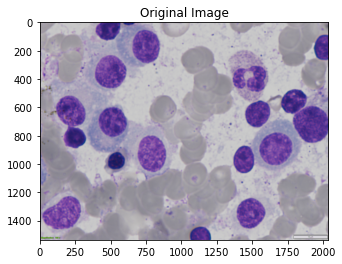

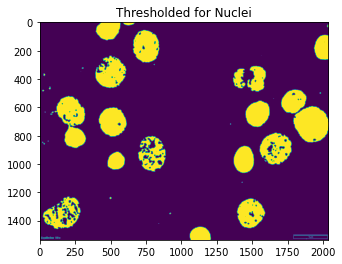

<class 'numpy.ndarray'>


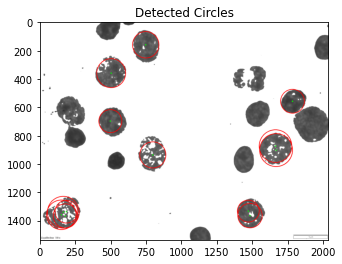

Number of elements:  8


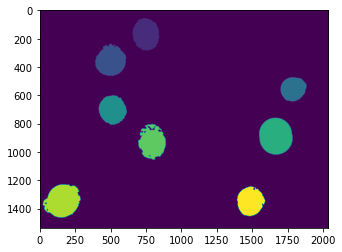

Number of elements:  11


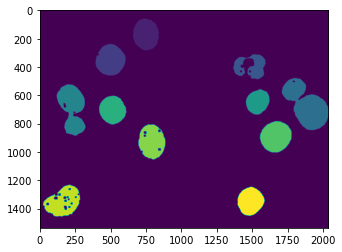

1 and 1
2 and 2
3 and 4
3 and 6
4 and 7
5 and 8
6 and 9
7 and 10


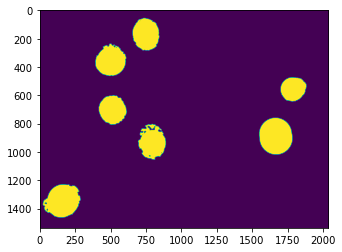

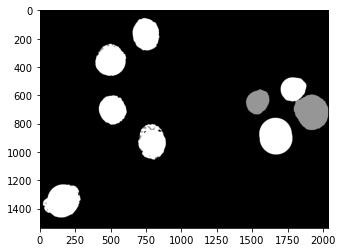

['9602_1.bmp', '9602_2.bmp', '9602_3.bmp', '9602_4.bmp']
1/4 9602_1.bmp
2/4 9602_2.bmp
3/4 9602_3.bmp
4/4 9602_4.bmp


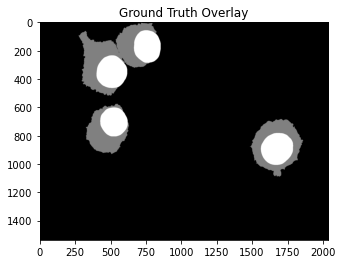

Nuc Count 4
Cyt Count 4
result_values = ((Prec_nuc,Recall_nuc,F1_nuc),(Prec_cyt,Recall_cyt,F1_cyt),(TP_nuc,FP_nuc,FN_nuc),(TP_cyt,FP_cyt,FN_cyt))
((0.5, 1.0, 0.6666666666666666), (0.36363636363636365, 1.0, 0.5333333333333333), (4, 4, 0), (4, 7, 0))
1909.bmp 2/2


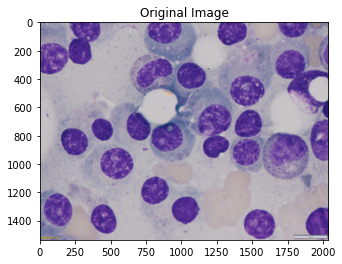

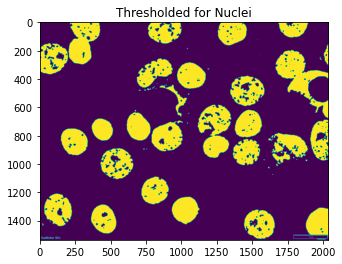

<class 'numpy.ndarray'>


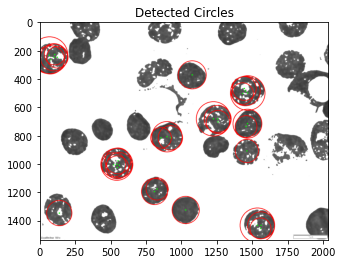

/var/folders/wk/yhz8hy0j69x6x9z1dg718pkm0000gn/T/ipykernel_2169/1568295650.py:103: RuntimeWarning: overflow encountered in ushort_scalars
  y_limits = [max(0, cen[0] - r), min(y-1, cen[0] + r)] #look at min and max of each y coord of circle


Number of elements:  11


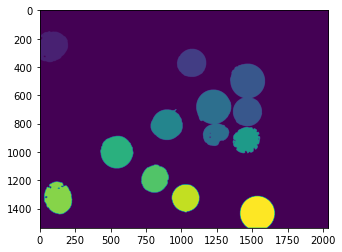

Number of elements:  22


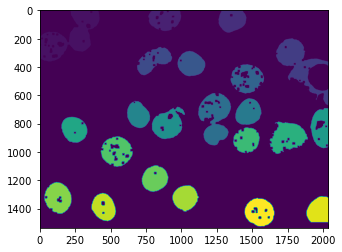

1 and 1
2 and 6
3 and 7
3 and 9
4 and 8
5 and 10
5 and 11
6 and 15
7 and 16
8 and 17
8 and 19
9 and 18


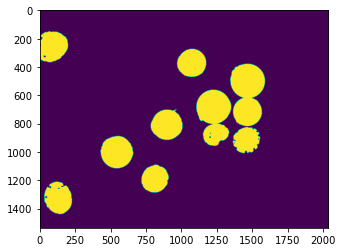

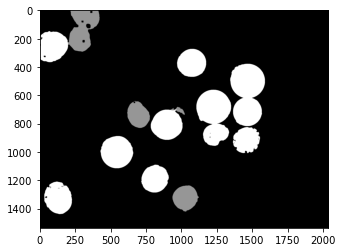

['1909_2.bmp', '1909_12.bmp', '1909_3.bmp', '1909_1.bmp', '1909_11.bmp', '1909_10.bmp', '1909_4.bmp', '1909_5.bmp', '1909_7.bmp', '1909_6.bmp', '1909_8.bmp', '1909_9.bmp']
1/12 1909_2.bmp
2/12 1909_12.bmp
3/12 1909_3.bmp
4/12 1909_1.bmp
5/12 1909_11.bmp
6/12 1909_10.bmp
7/12 1909_4.bmp
8/12 1909_5.bmp
9/12 1909_7.bmp
10/12 1909_6.bmp
11/12 1909_8.bmp
12/12 1909_9.bmp


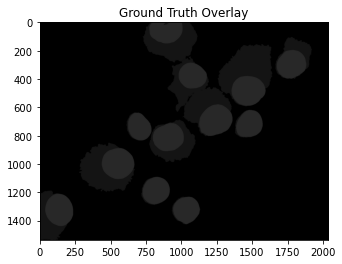

Nuc Count 12
Cyt Count 7
result_values = ((Prec_nuc,Recall_nuc,F1_nuc),(Prec_cyt,Recall_cyt,F1_cyt),(TP_nuc,FP_nuc,FN_nuc),(TP_cyt,FP_cyt,FN_cyt))
((1.0, 0.9166666666666666, 0.9565217391304348), (0.3181818181818182, 1.0, 0.4827586206896552), (11, 0, 1), (7, 15, 0))
1935.bmp 3/2
Nuclei Averages
Precision: 0.75
Recall: 0.9583333333333333
F1 Score:0.8115942028985508
Cytoplasm Averages
Precision: 0.34090909090909094
Recall: 1.0
F1 Score:0.5080459770114942
Combined Averages
Precision: 0.5454545454545454
Recall: 0.9791666666666666
F1 Score:0.6598200899550225
Nuclei Averages
Precision: 0.75
Recall: 0.9583333333333333
F1 Score:0.8115942028985508
Cytoplasm Averages
Precision: 0.75
Recall: 0.9583333333333333
F1 Score:0.8115942028985508
Combined Averages
Precision: 0.75
Recall: 0.9583333333333333
F1 Score:0.8115942028985508
2/2 files worked
['9602.bmp', '1909.bmp']
0/2 files crashed
[]


In [35]:
mypath = './'
bmp_files = [f for f in listdir(mypath) if isfile(f'{mypath}/{f}') and f.endswith('.bmp')]

print(bmp_files)

prec_sum_nuc = 0
recall_sum_nuc = 0
f1_sum_nuc = 0

prec_sum_cyt = 0
recall_sum_cyt = 0
f1_sum_cyt = 0

prec_sum_both = 0
recall_sum_both = 0
f1_sum_both = 0

prec_sums_nucs = []
recall_sums_nucs = []
f1_sums_nucs = []

prec_sums_cyts = []
recall_sums_cyts = []
f1_sums_cyts = []

max_files = 2 # How many files to check
# max_files = len(bmp_files) # Uncomment this line to check every bmp file
file_count = 0 # Keep track of how many weve checked so far
files_that_worked = []
files_that_crashed = []
for file_index in range(0,len(bmp_files)):
    
    filename = bmp_files[file_index]
    print(f'{filename} {file_count+1}/{max_files}')

    if file_count >= max_files: # If weve counted too many files. Break out of the loop
        break

    try:
        metrics = get_accuracy_metrics(filename) # Make sure this line is not commented when looping through files
        #metrics = get_accuracy_metrics("108.bmp") # Comment this line out to loop through files
    except:
        print(f'File Crashed: {filename}')
        files_that_crashed.append(filename)
    else:
        metrics_nuc, metrics_cyt, raw_nuc, raw_cyt = metrics

        prec_sum_nuc += metrics_nuc[0]
        recall_sum_nuc += metrics_nuc[1]
        f1_sum_nuc += metrics_nuc[2]
        

        prec_sum_cyt += metrics_cyt[0]
        recall_sum_cyt += metrics_cyt[1]
        f1_sum_cyt += metrics_cyt[2]

        prec_sums_nucs.append(metrics_nuc[0])
        recall_sums_nucs.append(metrics_nuc[1])
        f1_sums_nucs.append(metrics_nuc[2])

        prec_sums_cyts.append(metrics_nuc[0])
        recall_sums_cyts.append(metrics_nuc[1])
        f1_sums_cyts.append(metrics_nuc[2])

        #prec_sum_both += metrics_nuc[0] 
        #recall_sum_cyt += metrics_cyt[1]
        #f1_sum_cyt += metrics_cyt[2]    

        print("result_values = ((Prec_nuc,Recall_nuc,F1_nuc),(Prec_cyt,Recall_cyt,F1_cyt),(TP_nuc,FP_nuc,FN_nuc),(TP_cyt,FP_cyt,FN_cyt))")
        print(metrics)
        file_count = file_count + 1
        files_that_worked.append(filename)
    
    
#prec_avg_nuc = prec_sum_nuc / file_count
#recall_avg_nuc = recall_sum_nuc / file_count
#f1_avg_nuc = f1_sum_nuc / file_count

#prec_avg_cyt = prec_sum_cyt / file_count
#recall_avg_cyt = recall_sum_cyt / file_count
#f1_avg_cyt = f1_sum_cyt / file_count
    
#prec_avg_both = (prec_sum_nuc + prec_sum_cyt) / (2 * file_count)
#recall_avg_both = (recall_sum_nuc + recall_sum_cyt) / (2 * file_count)
#f1_avg_both = (f1_sum_nuc + f1_sum_cyt) / (2 * file_count)

prec_avg_nuc = np.array(prec_sums_nucs).mean()
recall_avg_nuc = np.array(recall_sums_nucs).mean()
f1_avg_nuc = np.array(f1_sums_nucs).mean()

prec_avg_cyt = np.array(prec_sums_cyts).mean()
recall_avg_cyt = np.array(recall_sums_cyts).mean()
f1_avg_cyt = np.array(f1_sums_cyts).mean()

prec_avg_both = np.concatenate((prec_sums_nucs, prec_sums_cyts)).mean()
recall_avg_both = np.concatenate((recall_sums_nucs, recall_sums_cyts)).mean()
f1_avg_both = np.concatenate((f1_sums_nucs, f1_sums_cyts)).mean()


print(f'Nuclei Averages\nPrecision: {prec_avg_nuc}\nRecall: {recall_avg_nuc}\nF1 Score:{f1_avg_nuc}')
print(f'Cytoplasm Averages\nPrecision: {prec_avg_cyt}\nRecall: {recall_avg_cyt}\nF1 Score:{f1_avg_cyt}')
print(f'Combined Averages\nPrecision: {prec_avg_both}\nRecall: {recall_avg_both}\nF1 Score:{f1_avg_both}')

nFilesSuccess = len(files_that_worked)
nFilesFailed = len(files_that_crashed)

print(f"{nFilesSuccess}/{nFilesSuccess+nFilesFailed} files worked")
print(files_that_worked)
print(f"{nFilesFailed}/{nFilesSuccess+nFilesFailed} files crashed")
print(files_that_crashed)


In [33]:
#print(get_accuracy_metrics('2352.bmp'))
#print(files_that_crashed)
#for xfile in files_that_crashed:
    #fnum = xfile.split('.')[0]
    #if isfile(f'../y/{fnum}_1.bmp'):
        #print(f'{xfile} Crashed With GT Starter')
    #else:
        #print(f'{xfile} Crashed Missing GT Starter')
np.concatenate((files_that_worked, files_that_crashed))[0]

'9602.bmp'

In [25]:
#gt_path = '../y/'
#gt_files = [f for f in listdir(gt_path) if isfile(f'{gt_path}/{f}') and f.startswith('1985_') and f.endswith('.bmp')]
#print(gt_files)
#for gtfile in gt_files:
    #print(gtfile)

['1985_2.bmp', '1985_6.bmp', '1985_4.bmp', '1985_5.bmp']
1985_2.bmp
1985_6.bmp
1985_4.bmp
1985_5.bmp


130